# Lấy dữ liệu

In [ ]:
!git clone https://github.com/James2109/CS114.N21.KHCL.git

Cloning into 'CS114.N21.KHCL'...
remote: Enumerating objects: 16067, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 16067 (delta 0), reused 21 (delta 0), pack-reused 16025
Receiving objects: 100% (16067/16067), 227.84 MiB | 32.22 MiB/s, done.
Resolving deltas: 100% (200/200), done.
Updating files: 100% (38801/38801), done.


In [ ]:
data_path = '/content/CS114.N21.KHCL/dataset'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Khai báo những thư viện cần thiết

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

# Dò tìm vị trí của logo

In [ ]:
def detect_logo(img):
    img_gray = cv2.GaussianBlur(img, (5, 5), 0)
    edges = cv2.Canny(img_gray, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    logo_images = []

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 1000:  # Điều kiện diện tích tối thiểu của logo
            x, y, w, h = cv2.boundingRect(contour)
            logo_image = img[y:y+h, x:x+w]
            #resized_logo = cv2.resize(logo_image, (img.shape[1], img.shape[0]))
            logo_images.append(logo_image)

    return logo_images[0] if len(logo_images) == 1 else img

#Đọc dữ liệu

In [ ]:
classes = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]
len(classes)

70

# Xử lí dữ liệu cho DeepLearning

In [ ]:
data_frames = []

for i_class in classes:
    image_path = os.path.join(data_path, i_class)

    for img in os.listdir(image_path):
        image_file = os.path.join(image_path, img)
        img = cv2.imread(image_file, 1)
        img = detect_logo(img)
        img = cv2.resize(img, (224, 224))

        label = i_class

        data_frames.append({'Pixel': img, 'label': label})

data = pd.DataFrame(data_frames)


In [ ]:
X = data['Pixel']
X = np.stack(X)
le = LabelEncoder()
y = le.fit_transform(data['label'])
y = to_categorical(y, num_classes = len(classes))

#Xử lí dữ liệu cho SVM

In [ ]:
data_frames = []

for i_class in classes:
    image_path = os.path.join(data_path, i_class)

    for img in os.listdir(image_path):
        image_file = os.path.join(image_path, img)
        img = cv2.imread(image_file, 0)
        img = detect_logo(img)
        img = cv2.resize(img, (224, 224))

        label = i_class

        data_frames.append({'Pixel': img, 'label': label})

data = pd.DataFrame(data_frames)

In [ ]:
X = data['Pixel']
X = np.stack(X)
X = X.reshape(X.shape[0], - 1)
le = LabelEncoder()
y = le.fit_transform(data['label'])

#Chia tập dữ liệu

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

#Support Vector Machine

In [ ]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train/255., y_train)
y_pred = model.predict(X_test/255.)
acc = accuracy_score(y_test, y_pred)
acc

0.38485947416137806

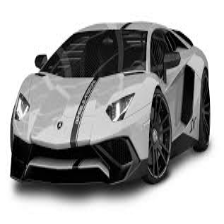

'sunbeam'

In [ ]:
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/CS114.N21.KHCL/dataset/lamborghini/logo_62.jpg',0)
img = detect_logo(img)
img = cv2.resize(img, (224, 224))
cv2_imshow(img)
classes[len(classes) - 1 - model.predict(img.reshape(1, -1))[0]]

In [ ]:
import joblib
# Save
joblib.dump(model, "/content/drive/MyDrive/model_SVM/SVM.pkl")

# load
#model = joblib.load("SVM.pkl")

['/content/drive/MyDrive/model_SVM/SVM.pkl']

#VGG16

In [ ]:
VGG = keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
from keras import layers
data_augmentation = tf.keras.Sequential([
  layers.Rescaling(scale=1/255.),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(factor=0.2),
  layers.RandomZoom(height_factor=0.1, width_factor=0.1),
  layers.RandomTranslation(height_factor=.1, width_factor=.1)
])
vgg_layer_list = VGG.layers

model = keras.Sequential ([data_augmentation])

for layer in vgg_layer_list:
    model.add(layer)

for layer in model.layers:
    layer.trainable = False

model.add(layers.Flatten())
model.add(layers.Dense(1024))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(256))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(len(classes)))
model.add(layers.Activation('softmax'))

In [ ]:
model.compile(optimizer='Adam',
              loss = "categorical_crossentropy",
              metrics= 'accuracy')

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.fit(x = X_train,
          y = y_train,
          batch_size=32,
          epochs = 50,
          callbacks=[model_checkpoint_callback],
)

Epoch 1/50
276/276 [==============================] - 71s 244ms/step - loss: 3.9685 - accuracy: 0.0881
Epoch 2/50
276/276 [==============================] - 71s 258ms/step - loss: 3.1069 - accuracy: 0.2418
Epoch 3/50
276/276 [==============================] - 76s 277ms/step - loss: 2.7180 - accuracy: 0.3208
Epoch 4/50
276/276 [==============================] - 76s 276ms/step - loss: 2.5160 - accuracy: 0.3710
Epoch 5/50
276/276 [==============================] - 79s 286ms/step - loss: 2.3242 - accuracy: 0.4170
Epoch 6/50
276/276 [==============================] - 86s 311ms/step - loss: 2.2159 - accuracy: 0.4372
Epoch 7/50
276/276 [==============================] - 92s 333ms/step - loss: 2.1244 - accuracy: 0.4610
Epoch 8/50
276/276 [==============================] - 88s 320ms/step - loss: 2.0773 - accuracy: 0.4705
Epoch 9/50
276/276 [==============================] - 87s 315ms/step - loss: 2.0009 - accuracy: 0.4906
Epoch 10/50
276/276 [==============================] - 92s 334ms/step - l

KeyboardInterrupt: ignored

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)    

In [ ]:
model.evaluate(X_test, y_test)

69/69 [==============================] - 9s 123ms/step - loss: 1.0397 - accuracy: 0.7353


[1.0397298336029053, 0.7352674603462219]

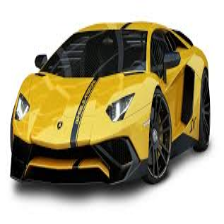

1/1 [==============================] - 0s 31ms/step


'lamborghini'

In [ ]:
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/CS114.N21.KHCL/dataset/lamborghini/logo_62.jpg',1)
img = detect_logo(img)
img = cv2.resize(img, (224, 224))
cv2_imshow(img)
img = tf.expand_dims(img, axis=0)
classes[len(classes) - 1 - np.argmax(model.predict(img))]

#VGG19


In [ ]:
VGG19 = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
)

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
from keras import layers
data_augmentation = tf.keras.Sequential([
  layers.Rescaling(scale=1/255.),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(factor=0.2),
  layers.RandomZoom(height_factor=0.1, width_factor=0.1),
  layers.RandomTranslation(height_factor=.1, width_factor=.1)
])
VGG19_layer_list = VGG19.layers

model = keras.Sequential ([data_augmentation])

for layer in VGG19_layer_list:
    model.add(layer)

for layer in model.layers:
    layer.trainable = False

model.add(layers.Flatten())
model.add(layers.Dense(1024))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(256))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(len(classes)))
model.add(layers.Activation('softmax'))

In [ ]:
model.compile(optimizer='Adam',
              loss = "categorical_crossentropy",
              metrics= 'accuracy')

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.fit(x = X_train,
          y = y_train,
          batch_size=32,
          epochs = 30,
          callbacks=[model_checkpoint_callback],
)

Epoch 1/30
276/276 [==============================] - 62s 168ms/step - loss: 4.0664 - accuracy: 0.0772
Epoch 2/30
276/276 [==============================] - 45s 163ms/step - loss: 3.3103 - accuracy: 0.1967
Epoch 3/30
276/276 [==============================] - 51s 186ms/step - loss: 2.9258 - accuracy: 0.2696
Epoch 4/30
276/276 [==============================] - 52s 188ms/step - loss: 2.7284 - accuracy: 0.3207
Epoch 5/30
276/276 [==============================] - 52s 189ms/step - loss: 2.5423 - accuracy: 0.3607
Epoch 6/30
276/276 [==============================] - 56s 203ms/step - loss: 2.4511 - accuracy: 0.3779
Epoch 7/30
276/276 [==============================] - 55s 199ms/step - loss: 2.3489 - accuracy: 0.4084
Epoch 8/30
276/276 [==============================] - 57s 206ms/step - loss: 2.2774 - accuracy: 0.4176
Epoch 9/30
276/276 [==============================] - 67s 243ms/step - loss: 2.2138 - accuracy: 0.4395
Epoch 10/30
276/276 [==============================] - 62s 226ms/step - l

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)    

In [ ]:
model.evaluate(X_test, y_test)

69/69 [==============================] - 16s 220ms/step - loss: 1.4689 - accuracy: 0.6505


[1.4688658714294434, 0.650498628616333]

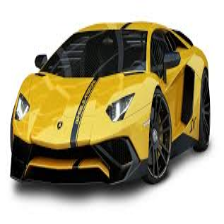

1/1 [==============================] - 1s 847ms/step


'volvo'

In [ ]:
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/CS114.N21.KHCL/dataset/lamborghini/logo_62.jpg',1)
img = detect_logo(img)
img = cv2.resize(img, (224, 224))
cv2_imshow(img)
img = tf.expand_dims(img, axis=0)
classes[len(classes) - 1 - np.argmax(model.predict(img))]

In [ ]:
model.save('/content/drive/MyDrive/model_VGG19')